## Imports & Utils

### Import

In [18]:
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

import umap

from PIL import Image

import bz2
import pickle
import _pickle as cPickle
import pathlib
from os.path import join

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm.notebook import trange
import cv2
from scipy.special import entr
import scipy
from copy import deepcopy
from torchvision.utils import save_image

from torch import distributed as dist
from torch.utils import data
import os
from torch import multiprocessing as mp

import sys
from torch import nn, optim
from tqdm import tqdm
from scheduler import CycleScheduler


In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# torch.cuda.set_device(1)

In [3]:
def make_dirs(path):
    pathlib.Path(path).mkdir(parents=True, exist_ok=True)

def compress_pickle(fname, data):
    with bz2.BZ2File(fname, 'wb') as f:
        cPickle.dump(data, f)

def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data

In [4]:
def rolling_window(array, window=(0,), asteps=None, wsteps=None, axes=None, toend=True):
    """Create a view of `array` which for every point gives the n-dimensional
    neighbourhood of size window. New dimensions are added at the end of
    `array` or after the corresponding original dimension.
    
    Parameters
    ----------
    array : array_like
        Array to which the rolling window is applied.
    window : int or tuple
        Either a single integer to create a window of only the last axis or a
        tuple to create it for the last len(window) axes. 0 can be used as a
        to ignore a dimension in the window.
    asteps : tuple
        Aligned at the last axis, new steps for the original array, ie. for
        creation of non-overlapping windows. (Equivalent to slicing result)
    wsteps : int or tuple (same size as window)
        steps for the added window dimensions. These can be 0 to repeat values
        along the axis.
    axes: int or tuple
        If given, must have the same size as window. In this case window is
        interpreted as the size in the dimension given by axes. IE. a window
        of (2, 1) is equivalent to window=2 and axis=-2.       
    toend : bool
        If False, the new dimensions are right after the corresponding original
        dimension, instead of at the end of the array. Adding the new axes at the
        end makes it easier to get the neighborhood, however toend=False will give
        a more intuitive result if you view the whole array.
    
    Returns
    -------
    A view on `array` which is smaller to fit the windows and has windows added
    dimensions (0s not counting), ie. every point of `array` is an array of size
    window.
    
    Examples
    --------
    >>> a = np.arange(9).reshape(3,3)
    >>> rolling_window(a, (2,2))
    array([[[[0, 1],
             [3, 4]],
            [[1, 2],
             [4, 5]]],
           [[[3, 4],
             [6, 7]],
            [[4, 5],
             [7, 8]]]])
    
    Or to create non-overlapping windows, but only along the first dimension:
    >>> rolling_window(a, (2,0), asteps=(2,1))
    array([[[0, 3],
            [1, 4],
            [2, 5]]])
    
    Note that the 0 is discared, so that the output dimension is 3:
    >>> rolling_window(a, (2,0), asteps=(2,1)).shape
    (1, 3, 2)
    
    This is useful for example to calculate the maximum in all (overlapping)
    2x2 submatrixes:
    >>> rolling_window(a, (2,2)).max((2,3))
    array([[4, 5],
           [7, 8]])
           
    Or delay embedding (3D embedding with delay 2):
    >>> x = np.arange(10)
    >>> rolling_window(x, 3, wsteps=2)
    array([[0, 2, 4],
           [1, 3, 5],
           [2, 4, 6],
           [3, 5, 7],
           [4, 6, 8],
           [5, 7, 9]])
    """
    array = np.asarray(array)
    orig_shape = np.asarray(array.shape)
    window = np.atleast_1d(window).astype(int) # maybe crude to cast to int...
    
    if axes is not None:
        axes = np.atleast_1d(axes)
        w = np.zeros(array.ndim, dtype=int)
        for axis, size in zip(axes, window):
            w[axis] = size
        window = w
    
    # Check if window is legal:
    if window.ndim > 1:
        raise ValueError("`window` must be one-dimensional.")
    if np.any(window < 0):
        raise ValueError("All elements of `window` must be larger then 1.")
    if len(array.shape) < len(window):
        raise ValueError("`window` length must be less or equal `array` dimension.") 

    _asteps = np.ones_like(orig_shape)
    if asteps is not None:
        asteps = np.atleast_1d(asteps)
        if asteps.ndim != 1:
            raise ValueError("`asteps` must be either a scalar or one dimensional.")
        if len(asteps) > array.ndim:
            raise ValueError("`asteps` cannot be longer then the `array` dimension.")
        # does not enforce alignment, so that steps can be same as window too.
        _asteps[-len(asteps):] = asteps
        
        if np.any(asteps < 1):
             raise ValueError("All elements of `asteps` must be larger then 1.")
    asteps = _asteps
    
    _wsteps = np.ones_like(window)
    if wsteps is not None:
        wsteps = np.atleast_1d(wsteps)
        if wsteps.shape != window.shape:
            raise ValueError("`wsteps` must have the same shape as `window`.")
        if np.any(wsteps < 0):
             raise ValueError("All elements of `wsteps` must be larger then 0.")

        _wsteps[:] = wsteps
        _wsteps[window == 0] = 1 # make sure that steps are 1 for non-existing dims.
    wsteps = _wsteps

    # Check that the window would not be larger then the original:
    if np.any(orig_shape[-len(window):] < window * wsteps):
        raise ValueError("`window` * `wsteps` larger then `array` in at least one dimension.")

    new_shape = orig_shape # just renaming...
    
    # For calculating the new shape 0s must act like 1s:
    _window = window.copy()
    _window[_window==0] = 1
    
    new_shape[-len(window):] += wsteps - _window * wsteps
    new_shape = (new_shape + asteps - 1) // asteps
    # make sure the new_shape is at least 1 in any "old" dimension (ie. steps
    # is (too) large, but we do not care.
    new_shape[new_shape < 1] = 1
    shape = new_shape
    
    strides = np.asarray(array.strides)
    strides *= asteps
    new_strides = array.strides[-len(window):] * wsteps
    
    # The full new shape and strides:
    if toend:
        new_shape = np.concatenate((shape, window))
        new_strides = np.concatenate((strides, new_strides))
    else:
        _ = np.zeros_like(shape)
        _[-len(window):] = window
        _window = _.copy()
        _[-len(window):] = new_strides
        _new_strides = _
        
        new_shape = np.zeros(len(shape)*2, dtype=int)
        new_strides = np.zeros(len(shape)*2, dtype=int)
        
        new_shape[::2] = shape
        new_strides[::2] = strides
        new_shape[1::2] = _window
        new_strides[1::2] = _new_strides
    
    new_strides = new_strides[new_shape != 0]
    new_shape = new_shape[new_shape != 0]
    
    return np.lib.stride_tricks.as_strided(array, shape=new_shape, strides=new_strides)

### Distributed Utils

In [6]:
LOCAL_PROCESS_GROUP = None


def is_primary():
    return get_rank() == 0


def get_rank():
    if not dist.is_available():
        return 0

    if not dist.is_initialized():
        return 0

    return dist.get_rank()


def get_local_rank():
    if not dist.is_available():
        return 0

    if not dist.is_initialized():
        return 0

    if LOCAL_PROCESS_GROUP is None:
        raise ValueError("tensorfn.distributed.LOCAL_PROCESS_GROUP is None")

    return dist.get_rank(group=LOCAL_PROCESS_GROUP)


def synchronize():
    if not dist.is_available():
        return

    if not dist.is_initialized():
        return

    world_size = dist.get_world_size()

    if world_size == 1:
        return

    dist.barrier()


def get_world_size():
    if not dist.is_available():
        return 1

    if not dist.is_initialized():
        return 1

    return dist.get_world_size()


def all_reduce(tensor, op=dist.ReduceOp.SUM):
    world_size = get_world_size()

    if world_size == 1:
        return tensor

    dist.all_reduce(tensor, op=op)

    return tensor


def all_gather(data):
    world_size = get_world_size()

    if world_size == 1:
        return [data]

    buffer = pickle.dumps(data)
    storage = torch.ByteStorage.from_buffer(buffer)
    tensor = torch.ByteTensor(storage).to("cuda")

    local_size = torch.IntTensor([tensor.numel()]).to("cuda")
    size_list = [torch.IntTensor([1]).to("cuda") for _ in range(world_size)]
    dist.all_gather(size_list, local_size)
    size_list = [int(size.item()) for size in size_list]
    max_size = max(size_list)

    tensor_list = []
    for _ in size_list:
        tensor_list.append(torch.ByteTensor(size=(max_size,)).to("cuda"))

    if local_size != max_size:
        padding = torch.ByteTensor(size=(max_size - local_size,)).to("cuda")
        tensor = torch.cat((tensor, padding), 0)

    dist.all_gather(tensor_list, tensor)

    data_list = []

    for size, tensor in zip(size_list, tensor_list):
        buffer = tensor.cpu().numpy().tobytes()[:size]
        data_list.append(pickle.loads(buffer))

    return data_list


def reduce_dict(input_dict, average=True):
    world_size = get_world_size()

    if world_size < 2:
        return input_dict

    with torch.no_grad():
        keys = []
        values = []

        for k in sorted(input_dict.keys()):
            keys.append(k)
            values.append(input_dict[k])

        values = torch.stack(values, 0)
        dist.reduce(values, dst=0)

        if dist.get_rank() == 0 and average:
            values /= world_size

        reduced_dict = {k: v for k, v in zip(keys, values)}

    return reduced_dict


def data_sampler(dataset, shuffle, distributed):
    if distributed:
        return data.distributed.DistributedSampler(dataset, shuffle=shuffle)

    if shuffle:
        return data.RandomSampler(dataset)

    else:
        return data.SequentialSampler(dataset)

def find_free_port():
    import socket

    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

    sock.bind(("", 0))
    port = sock.getsockname()[1]
    sock.close()

    return port


def launch(fn, n_gpu_per_machine, n_machine=1, machine_rank=0, dist_url=None, args=()):
    world_size = n_machine * n_gpu_per_machine

    if world_size > 1:
        if "OMP_NUM_THREADS" not in os.environ:
            os.environ["OMP_NUM_THREADS"] = "1"

        if dist_url == "auto":
            if n_machine != 1:
                raise ValueError('dist_url="auto" not supported in multi-machine jobs')

            port = find_free_port()
            dist_url = f"tcp://127.0.0.1:{port}"

        if n_machine > 1 and dist_url.startswith("file://"):
            raise ValueError(
                "file:// is not a reliable init method in multi-machine jobs. Prefer tcp://"
            )

        mp.spawn(
            distributed_worker,
            nprocs=n_gpu_per_machine,
            args=(fn, world_size, n_gpu_per_machine, machine_rank, dist_url, args),
            daemon=False,
        )

    else:
        fn(*args)


def distributed_worker(
    local_rank, fn, world_size, n_gpu_per_machine, machine_rank, dist_url, args
):
    if not torch.cuda.is_available():
        raise OSError("CUDA is not available. Please check your environments")

    global_rank = machine_rank * n_gpu_per_machine + local_rank

    try:
        dist.init_process_group(
            backend="NCCL",
            init_method=dist_url,
            world_size=world_size,
            rank=global_rank,
        )

    except Exception:
        raise OSError("failed to initialize NCCL groups")

    synchronize()

    if n_gpu_per_machine > torch.cuda.device_count():
        raise ValueError(
            f"specified n_gpu_per_machine larger than available device ({torch.cuda.device_count()})"
        )

    torch.cuda.set_device(local_rank)

    if LOCAL_PROCESS_GROUP is not None:
        raise ValueError("torch.distributed.LOCAL_PROCESS_GROUP is not None")

    n_machine = world_size // n_gpu_per_machine

    for i in range(n_machine):
        ranks_on_i = list(range(i * n_gpu_per_machine, (i + 1) * n_gpu_per_machine))
        pg = dist.new_group(ranks_on_i)

        if i == machine_rank:
            LOCAL_PROCESS_GROUP = pg

    fn(*args)

## Load Data (MNIST)

### Mutli-scale MNIST

In [7]:
class MNISTMultiScale(torch.utils.data.Dataset):
    def __init__(self, path, split='train', transform=None, size=(224, 224), blur=False, crop=True):
        df = decompress_pickle(join(path, '{}.pbz2'.format(split)))
        self.img_names = df['fname']
        self.y = df['target']

        self.transform = transform
        self.path = path
        self.split = split

        self.data = np.empty((len(self.img_names), size[0], size[1], 3), dtype=np.float32)

        for i in range(len(self.img_names)):

            img = np.array(
                            Image.open(join(self.path, self.split, '{}.png'.format(self.img_names[i]))).convert('RGB'),
                        ) / 255.

            if crop:
                img = img[:size[0], :size[1], :]

            if blur:
                img = cv2.GaussianBlur(
                        img,
                        (3,3),
                        0
                    )

            self.data[i, :, :, :] = img

    def __getitem__(self, index):
        img = self.data[index, :, :, :]

        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return len(self.img_names)

In [8]:
custom_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST),
                                    #   transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                  ])

FV = {}
FV['train'] = MNISTMultiScale('/mnt/data/rochan/cancer/dataset/mnist-small-ms/', 'train', custom_transform, size=(170, 170))
FV['test'] = MNISTMultiScale('/mnt/data/rochan/cancer/dataset/mnist-small-ms/', 'test', custom_transform, size=(170, 170))


custom_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST),
                                      transforms.RandomCrop((64, 64)),
                                    #   transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                  ])

PV = {}
PV['train'] = MNISTMultiScale('/mnt/data/rochan/cancer/dataset/mnist-small-ms/', 'train', custom_transform, size=(170, 170))
PV['test'] = MNISTMultiScale('/mnt/data/rochan/cancer/dataset/mnist-small-ms/', 'test', custom_transform, size=(170, 170))

### Double MNIST

In [ ]:
custom_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                  ])

FV = {}
FV['train'] = ImageFolder('/mnt/data/rochan/cancer/dataset/double_mnist/train', custom_transform)
FV['test'] = ImageFolder('/mnt/data/rochan/cancer/dataset/double_mnist/test', custom_transform)


custom_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.RandomCrop((14, 14)),
                                      transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                  ])

PV = {}
PV['train'] = ImageFolder('/mnt/data/rochan/cancer/dataset/double_mnist/train', custom_transform)
PV['test'] = ImageFolder('/mnt/data/rochan/cancer/dataset/double_mnist/test', custom_transform)

### Visualize

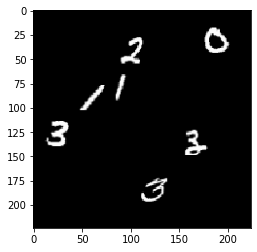

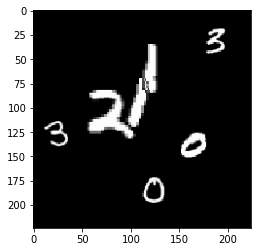

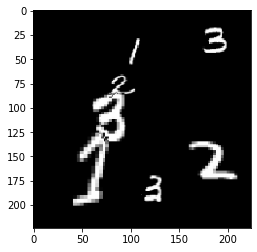

In [11]:
for idx, (image, _) in enumerate(FV['train']):
	plt.imshow(np.array(torch.permute(image, (1, 2, 0))), cmap='gray')
	plt.show()
	if idx == 2:
		break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


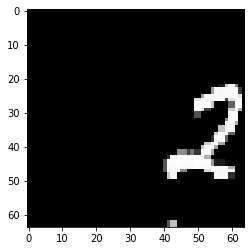

In [8]:
for image, _ in PV['train']:
	break

plt.imshow(np.array(torch.permute(image, (1, 2, 0))), cmap='gray')

## Models

In [11]:
class ResBlock(nn.Module):
    def __init__(self, in_channel, channel):
        super().__init__()

        self.conv = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channel, channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel, in_channel, 1),
        )

    def forward(self, input):
        out = self.conv(input)
        out += input

        return out

### VQ-VAE 2

In [10]:
class Quantize(nn.Module):
    def __init__(self, dim, n_embed, decay=0.99, eps=1e-5):
        super().__init__()

        self.dim = dim
        self.n_embed = n_embed
        self.decay = decay
        self.eps = eps

        embed = torch.randn(dim, n_embed)
        self.register_buffer("embed", embed)
        self.register_buffer("cluster_size", torch.zeros(n_embed))
        self.register_buffer("embed_avg", embed.clone())

    def forward(self, input):
        flatten = input.reshape(-1, self.dim)
        dist = (
            flatten.pow(2).sum(1, keepdim=True)
            - 2 * flatten @ self.embed
            + self.embed.pow(2).sum(0, keepdim=True)
        )
        _, embed_ind = (-dist).max(1)
        embed_onehot = F.one_hot(embed_ind, self.n_embed).type(flatten.dtype)
        embed_ind = embed_ind.view(*input.shape[:-1])
        quantize = self.embed_code(embed_ind)

        if self.training:
            embed_onehot_sum = embed_onehot.sum(0)
            embed_sum = flatten.transpose(0, 1) @ embed_onehot

            all_reduce(embed_onehot_sum)
            all_reduce(embed_sum)

            self.cluster_size.data.mul_(self.decay).add_(
                embed_onehot_sum, alpha=1 - self.decay
            )
            self.embed_avg.data.mul_(self.decay).add_(embed_sum, alpha=1 - self.decay)
            n = self.cluster_size.sum()
            cluster_size = (
                (self.cluster_size + self.eps) / (n + self.n_embed * self.eps) * n
            )
            embed_normalized = self.embed_avg / cluster_size.unsqueeze(0)
            self.embed.data.copy_(embed_normalized)

        diff = (quantize.detach() - input).pow(2).mean()
        quantize = input + (quantize - input).detach()

        return quantize, diff, embed_ind

    def embed_code(self, embed_id):
        return F.embedding(embed_id, self.embed.transpose(0, 1))

In [14]:
class Encoder(nn.Module):
    def __init__(self, in_channel, channel, n_res_block, n_res_channel, stride):
        super().__init__()

        if stride == 4:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel, channel, 3, padding=1),
            ]

        elif stride == 2:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 3, padding=1),
            ]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        self.blocks = nn.Sequential(*blocks)

    def forward(self, input):
        return self.blocks(input)


class Decoder(nn.Module):
    def __init__(
        self, in_channel, out_channel, channel, n_res_block, n_res_channel, stride
    ):
        super().__init__()

        blocks = [nn.Conv2d(in_channel, channel, 3, padding=1)]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        if stride == 4:
            blocks.extend(
                [
                    nn.ConvTranspose2d(channel, channel // 2, 4, stride=2, padding=1),
                    nn.ReLU(inplace=True),
                    nn.ConvTranspose2d(
                        channel // 2, out_channel, 4, stride=2, padding=1
                    ),
                ]
            )

        elif stride == 2:
            blocks.append(
                nn.ConvTranspose2d(channel, out_channel, 4, stride=2, padding=1)
            )

        self.blocks = nn.Sequential(*blocks)

    def forward(self, input):
        return self.blocks(input)

In [15]:
class VQVAE(nn.Module):
    def __init__(
        self,
        in_channel=3,
        channel=128,
        n_res_block=2,
        n_res_channel=32,
        embed_dim=64,
        n_embed=512,
        decay=0.99,
    ):
        super().__init__()

        self.enc_b = Encoder(in_channel, channel, n_res_block, n_res_channel, stride=4)
        self.enc_t = Encoder(channel, channel, n_res_block, n_res_channel, stride=2)
        self.quantize_conv_t = nn.Conv2d(channel, embed_dim, 1)
        self.quantize_t = Quantize(embed_dim, n_embed)
        self.dec_t = Decoder(
            embed_dim, embed_dim, channel, n_res_block, n_res_channel, stride=2
        )
        self.quantize_conv_b = nn.Conv2d(embed_dim + channel, embed_dim, 1)
        self.quantize_b = Quantize(embed_dim, n_embed)
        self.upsample_t = nn.ConvTranspose2d(
            embed_dim, embed_dim, 4, stride=2, padding=1
        )
        self.dec = Decoder(
            embed_dim + embed_dim,
            in_channel,
            channel,
            n_res_block,
            n_res_channel,
            stride=4,
        )

    def forward(self, input):
        quant_t, quant_b, diff, _, _ = self.encode(input)
        dec = self.decode(quant_t, quant_b)

        return dec, diff

    def encode(self, input):
        enc_b = self.enc_b(input)
        enc_t = self.enc_t(enc_b)

        quant_t = self.quantize_conv_t(enc_t).permute(0, 2, 3, 1)
        quant_t, diff_t, id_t = self.quantize_t(quant_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        diff_t = diff_t.unsqueeze(0)

        dec_t = self.dec_t(quant_t)
        enc_b = torch.cat([dec_t, enc_b], 1)

        quant_b = self.quantize_conv_b(enc_b).permute(0, 2, 3, 1)
        quant_b, diff_b, id_b = self.quantize_b(quant_b)
        quant_b = quant_b.permute(0, 3, 1, 2)
        diff_b = diff_b.unsqueeze(0)

        return quant_t, quant_b, diff_t + diff_b, id_t, id_b

    def decode(self, quant_t, quant_b):
        upsample_t = self.upsample_t(quant_t)
        quant = torch.cat([upsample_t, quant_b], 1)
        dec = self.dec(quant)

        return dec

    def decode_code(self, code_t, code_b):
        quant_t = self.quantize_t.embed_code(code_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        quant_b = self.quantize_b.embed_code(code_b)
        quant_b = quant_b.permute(0, 3, 1, 2)

        dec = self.decode(quant_t, quant_b)

        return dec

## Train

In [20]:
cfg_f = {
    'batch_size': 256,
    'steps': 4000,
    'lr': 1e-4
}

cfg_p = {
    'batch_size': 256,
    'steps': 4000,
    'lr': 1e-4
}

In [21]:
FVL = {}
FVL['train'] = DataLoader(FV['train'],
                             batch_size=cfg_f['batch_size'],
                             shuffle=True,
                             pin_memory=False)

FVL['test'] = DataLoader(FV['test'],
                             batch_size=32,
                             shuffle=True,
                             pin_memory=False)

PVL = {}
PVL['train'] = DataLoader(PV['train'],
                             batch_size=cfg_p['batch_size'],
                             shuffle=True,
                             pin_memory=True)

PVL['test'] = DataLoader(PV['test'],
                             batch_size=32,
                             shuffle=True,
                             pin_memory=True)

## Full Model Train

In [28]:
def train(epoch, loader, model, optimizer, scheduler, device):
    if is_primary():
        loader = tqdm(loader)

    criterion = nn.MSELoss()

    latent_loss_weight = 0.25
    sample_size = 25

    mse_sum = 0
    mse_n = 0

    for i, (img, label) in enumerate(loader):
        model.zero_grad()

        img = img.to(device)

        out, latent_loss = model(img)
        recon_loss = criterion(out, img)
        latent_loss = latent_loss.mean()
        loss = recon_loss + latent_loss_weight * latent_loss
        loss.backward()

        if scheduler is not None:
            scheduler.step()
        optimizer.step()

        part_mse_sum = recon_loss.item() * img.shape[0]
        part_mse_n = img.shape[0]
        comm = {"mse_sum": part_mse_sum, "mse_n": part_mse_n}
        comm = all_gather(comm)

        for part in comm:
            mse_sum += part["mse_sum"]
            mse_n += part["mse_n"]

        if is_primary():
            lr = optimizer.param_groups[0]["lr"]

            loader.set_description(
                (
                    f"epoch: {epoch + 1}; mse: {recon_loss.item():.5f}; "
                    f"latent: {latent_loss.item():.3f}; avg mse: {mse_sum / mse_n:.5f}; "
                    f"lr: {lr:.5f}"
                )
            )

            if i % 100 == 0:
                model.eval()

                sample = img[:sample_size]

                with torch.no_grad():
                    out, _ = model(sample)

                save_image(
                    torch.cat([sample, out], 0),
                    f"sample/{str(epoch + 1).zfill(5)}_{str(i).zfill(5)}.png",
                    nrow=sample_size,
                    normalize=True,
                    range=(-1, 1),
                )

                model.train()

In [32]:
def main(cfg_f):
    distributed = get_world_size() > 1

    sampler = data_sampler(FV['train'], shuffle=True, distributed=distributed)
    loader = DataLoader(
        FV['train'], batch_size=cfg_f['batch_size'] // 2, sampler=sampler, num_workers=2
    )

    model = VQVAE().to(device)

    if distributed:
        model = nn.parallel.DistributedDataParallel(
            model,
            device_ids=[get_local_rank()],
            output_device=get_local_rank(),
        )

    optimizer = optim.Adam(model.parameters(), lr=cfg_f['lr'])
    scheduler = None
    # if args.sched == "cycle":
    #     scheduler = CycleScheduler(
    #         optimizer,
    #         args.lr,
    #         n_iter=len(loader) * args.epoch,
    #         momentum=None,
    #         warmup_proportion=0.05,
    #     )

    for i in range(cfg_f['steps']):
        train(i, loader, model, optimizer, scheduler, device)

        if is_primary():
            torch.save(model.state_dict(), f"checkpoint/vqvae_{str(i + 1).zfill(3)}.pt")

In [33]:
port = (
	2 ** 15
	+ 2 ** 14
	+ hash(os.getuid() if sys.platform != "win32" else 1) % 2 ** 14
)
dist_url = "tcp://127.0.0.1:{}".format(port)

n_gpu = 1

launch(main, n_gpu, 1, 0, dist_url, args=(cfg_f,))

epoch: 1; mse: 0.03968; latent: 0.006; avg mse: 0.04920; lr: 0.00010: 100%|██████████| 40/40 [00:06<00:00,  6.01it/s]
epoch: 2; mse: 0.04307; latent: 0.011; avg mse: 0.04766; lr: 0.00010: 100%|██████████| 40/40 [00:06<00:00,  6.04it/s]
epoch: 3; mse: 0.04730; latent: 0.016; avg mse: 0.04762; lr: 0.00010: 100%|██████████| 40/40 [00:06<00:00,  6.04it/s]
epoch: 4; mse: 0.01843; latent: 0.014; avg mse: 0.03726; lr: 0.00010: 100%|██████████| 40/40 [00:06<00:00,  6.03it/s]
epoch: 5; mse: 0.00758; latent: 0.005; avg mse: 0.01207; lr: 0.00010: 100%|██████████| 40/40 [00:06<00:00,  6.01it/s]
epoch: 6; mse: 0.00852; latent: 0.011; avg mse: 0.00882; lr: 0.00010: 100%|██████████| 40/40 [00:06<00:00,  5.95it/s]
epoch: 7; mse: 0.00720; latent: 0.011; avg mse: 0.00798; lr: 0.00010: 100%|██████████| 40/40 [00:06<00:00,  5.95it/s]
epoch: 8; mse: 0.00770; latent: 0.013; avg mse: 0.00757; lr: 0.00010: 100%|██████████| 40/40 [00:06<00:00,  5.95it/s]
epoch: 9; mse: 0.00663; latent: 0.011; avg mse: 0.00730;

KeyboardInterrupt: 

In [42]:
def train_full(model, loader, cfg):
    optimizer = optim.Adam(model.parameters(), lr=cfg['lr'], amsgrad=False)
    model.train()
    model = model.to(device)
    train_res_recon_error = []
    train_res_perplexity = []

    for i in trange(cfg['steps']):
        (data, _) = next(iter(loader))

        data = data.to(device, dtype=torch.float32)
        optimizer.zero_grad()

        vq_loss, data_recon, perplexity, encodings, encodings_idx = model(data)
        recon_error = F.mse_loss(data_recon, data) / 0.1 #data_variance_F
        loss = recon_error + vq_loss
        loss.backward()

        optimizer.step()

        train_res_recon_error.append(recon_error.item())
        train_res_perplexity.append(perplexity.item())

        if (i+1) % 10 == 0:
            print('%d iterations' % (i+1))
            print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
            torch.save(model.state_dict(), 'vq_vae_double_mnist_full.pth')
            print()

    train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
    train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

    f = plt.figure(figsize=(16,8), dpi=200)
    ax = f.add_subplot(1,2,1)
    ax.plot(train_res_recon_error_smooth)
    ax.set_yscale('log')
    ax.set_title('Soft-VQ-VAE Smoothed NMSE.')
    ax.set_xlabel('iteration')

    ax = f.add_subplot(1,2,2)
    ax.plot(train_res_perplexity_smooth)
    ax.set_title('Soft-VQ-VAE Smoothed Average codebook usage (perplexity).')
    ax.set_xlabel('iteration')

    plt.savefig('soft_model_plot.png')

    return model

  0%|          | 0/4000 [00:00<?, ?it/s]

10 iterations
recon_error: 2.318

20 iterations
recon_error: 2.150

30 iterations
recon_error: 2.045

40 iterations
recon_error: 1.972

50 iterations
recon_error: 1.901

60 iterations
recon_error: 1.852

70 iterations
recon_error: 1.816

80 iterations
recon_error: 1.786

90 iterations
recon_error: 1.763

100 iterations
recon_error: 1.744

110 iterations
recon_error: 1.670

120 iterations
recon_error: 1.629

130 iterations
recon_error: 1.602

140 iterations
recon_error: 1.583

150 iterations
recon_error: 1.576

160 iterations
recon_error: 1.569

170 iterations
recon_error: 1.566

180 iterations
recon_error: 1.565

190 iterations
recon_error: 1.563

200 iterations
recon_error: 1.560

210 iterations
recon_error: 1.558

220 iterations
recon_error: 1.556

230 iterations
recon_error: 1.552

240 iterations
recon_error: 1.550

250 iterations
recon_error: 1.550

260 iterations
recon_error: 1.551

270 iterations
recon_error: 1.549

280 iterations
recon_error: 1.546

290 iterations
recon_error: 1

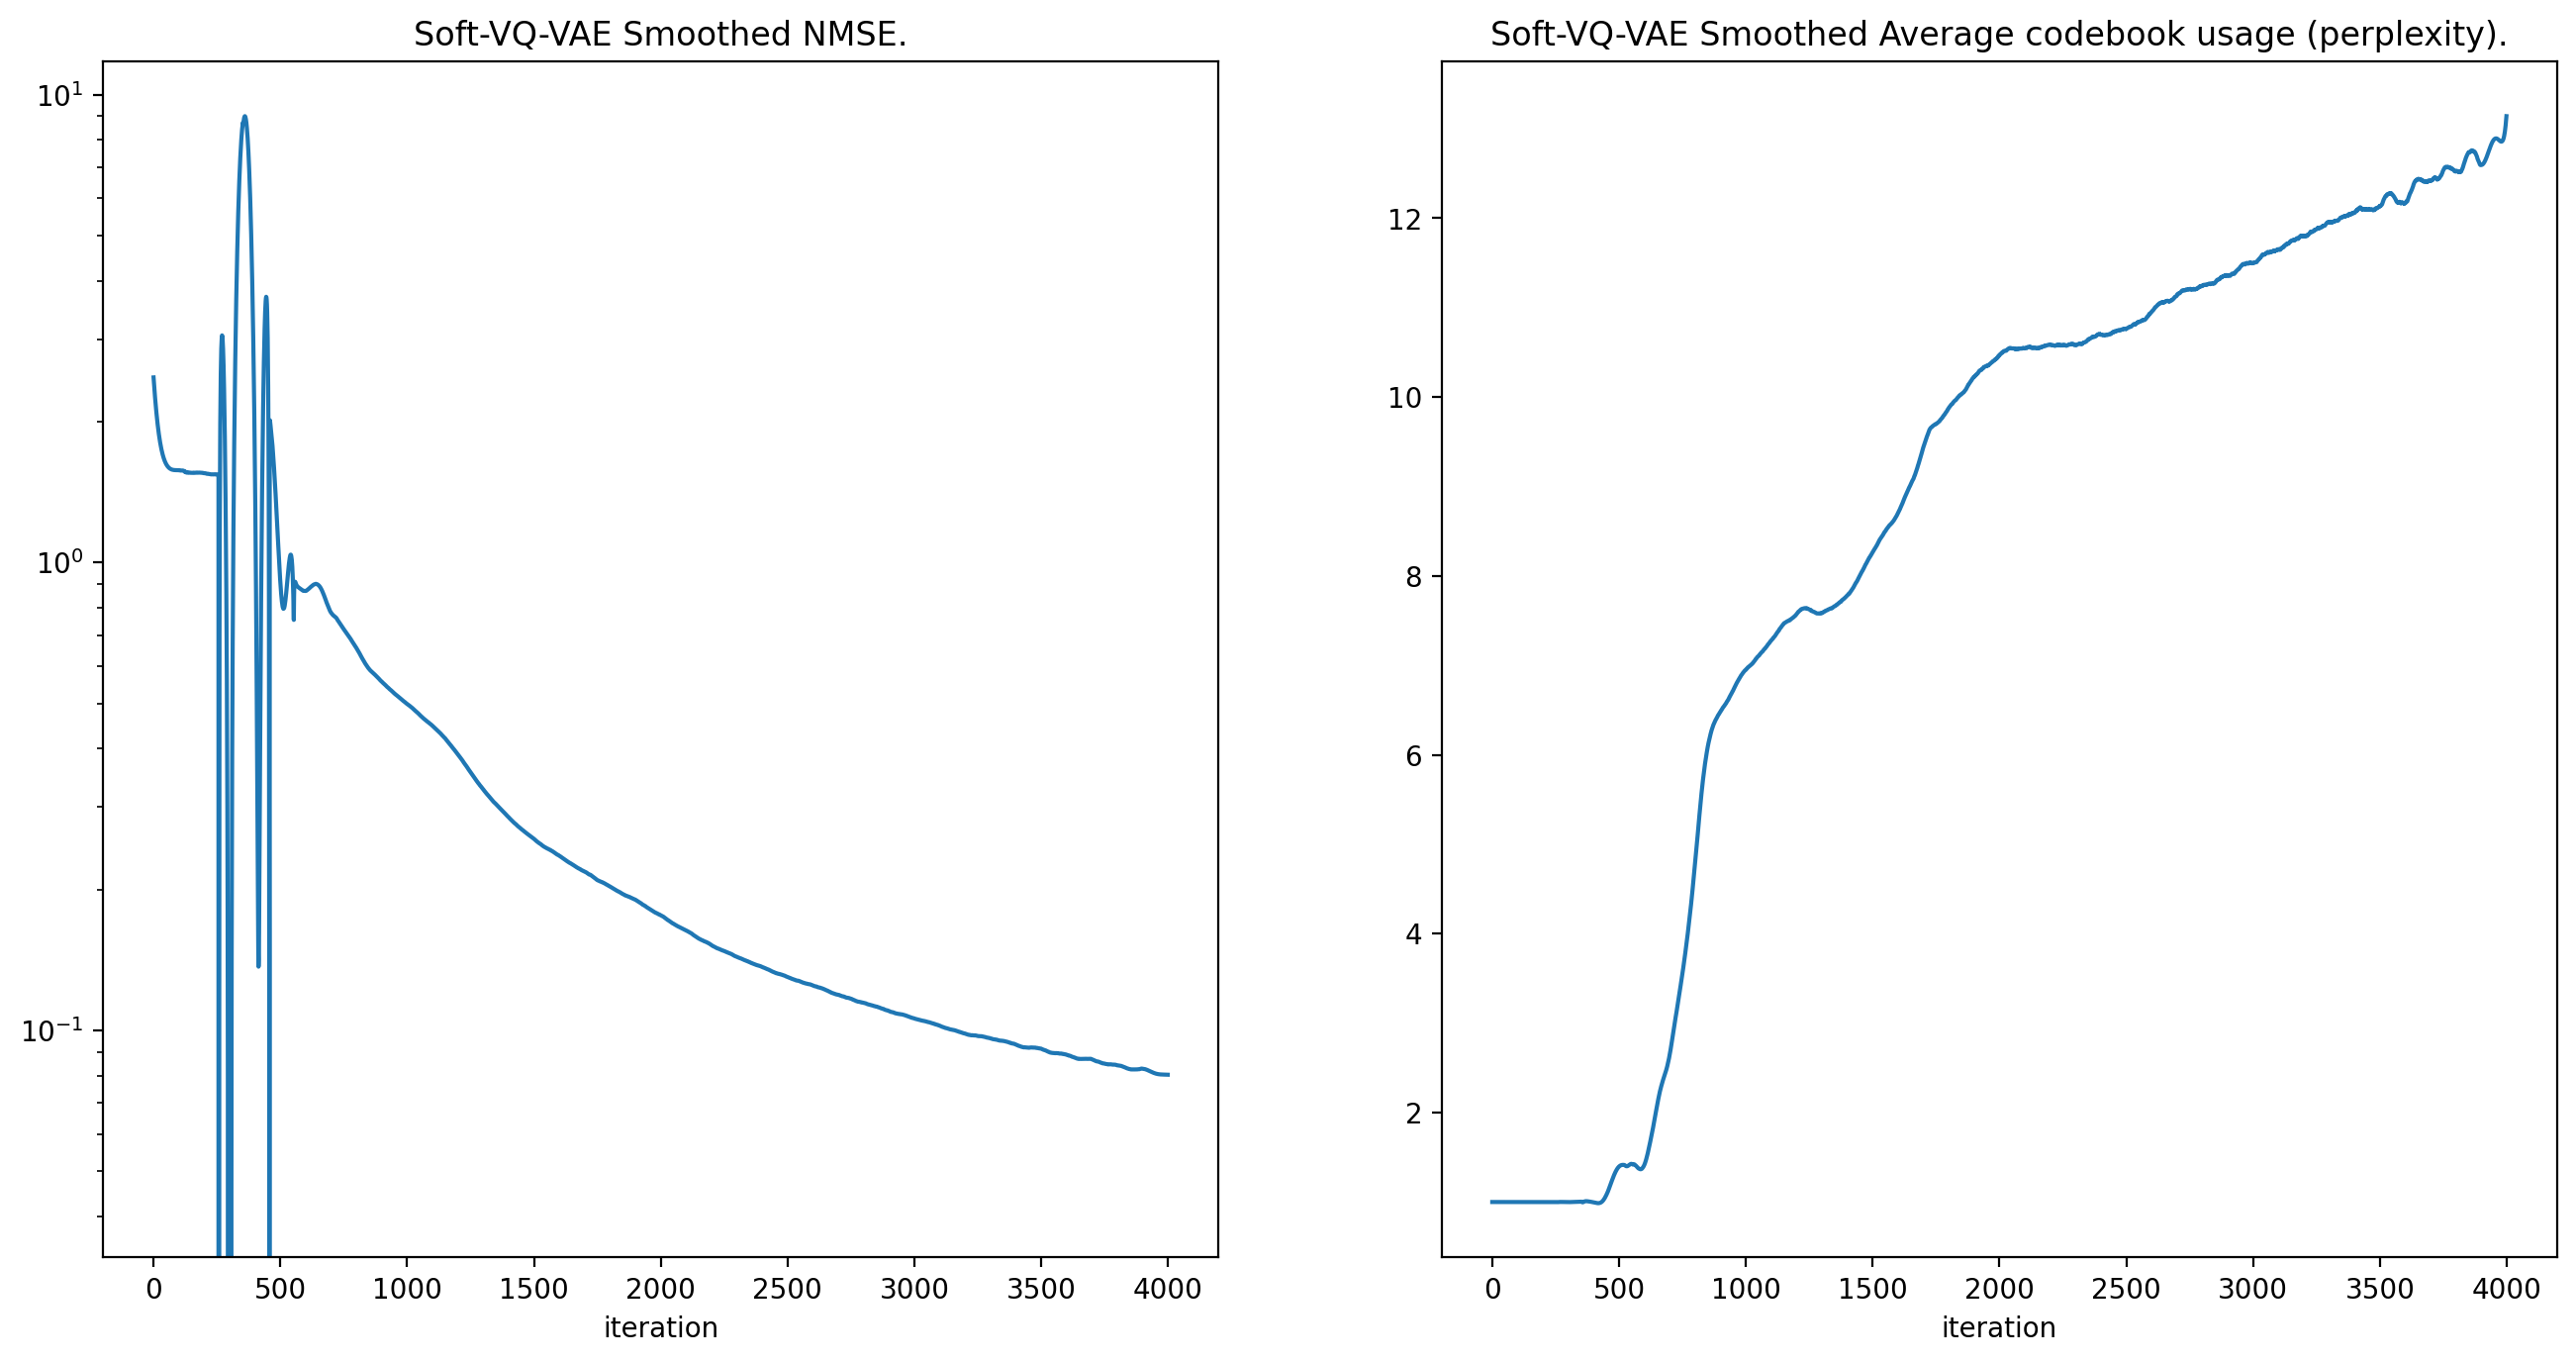

In [43]:
soft_model = train_full(soft_model, FVL['train'], cfg_f)

## Partial Model Train

In [51]:
def train_partial(model_base, model, loader, cfg):
    optimizer = optim.Adam(model.parameters(), lr=cfg['lr'], amsgrad=False)
    model.train()
    model = model.to(device)
    model_base = model_base.to(device)
    train_res_recon_error = []
    train_res_perplexity = []

    for i in trange(cfg['steps']):
        (data, _) = next(iter(loader))

        with torch.no_grad():
            _, _, _, _, encodings_idx = model_base(data.to(device, dtype=torch.float32))
            encodings_idx = encodings_idx.view(data.shape[0], 16, 16)/512.

        data = encodings_idx.flatten(1).to(dtype=torch.float32)

        optimizer.zero_grad()

        data_recon, vq_loss, perplexity, quantized = model(data)

        recon_error = F.mse_loss(data_recon, data)/(1/512)
        loss = recon_error + vq_loss
        loss.backward()

        optimizer.step()

        train_res_recon_error.append(recon_error.item())
        train_res_perplexity.append(perplexity.item())

        if (i+1) % 50 == 0:
            print('%d iterations' % (i+1))
            print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
            print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
            torch.save(model.state_dict(), 'vq_vae_double_mnist_partial.pth')
            print()

    train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
    train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

    f = plt.figure(figsize=(16,8), dpi=200)
    ax = f.add_subplot(1,2,1)
    ax.plot(train_res_recon_error_smooth)
    ax.set_yscale('log')
    ax.set_title('VQ-VAE Smoothed NMSE.')
    ax.set_xlabel('iteration')

    ax = f.add_subplot(1,2,2)
    ax.plot(train_res_perplexity_smooth)
    ax.set_title('VQ-VAE Smoothed Average codebook usage (perplexity).')
    ax.set_xlabel('iteration')

    plt.savefig('model_plot.png')

    return model

  0%|          | 0/4000 [00:00<?, ?it/s]

50 iterations
recon_error: 21.900
perplexity: 1.435

100 iterations
recon_error: 20.379
perplexity: 1.217

150 iterations
recon_error: 16.699
perplexity: 1.000

200 iterations
recon_error: 13.134
perplexity: 1.000

250 iterations
recon_error: 11.434
perplexity: 1.000

300 iterations
recon_error: 11.119
perplexity: 1.000

350 iterations
recon_error: 11.101
perplexity: 1.000

400 iterations
recon_error: 11.099
perplexity: 1.000

450 iterations
recon_error: 11.101
perplexity: 1.000

500 iterations
recon_error: 11.099
perplexity: 1.000

550 iterations
recon_error: 11.101
perplexity: 1.005

600 iterations
recon_error: 11.112
perplexity: 1.019

650 iterations
recon_error: 11.115
perplexity: 1.026

700 iterations
recon_error: 11.117
perplexity: 1.033

750 iterations
recon_error: 11.126
perplexity: 1.045

800 iterations
recon_error: 11.144
perplexity: 1.060

850 iterations
recon_error: 11.156
perplexity: 1.078

900 iterations
recon_error: 11.162
perplexity: 1.110

950 iterations
recon_error: 1

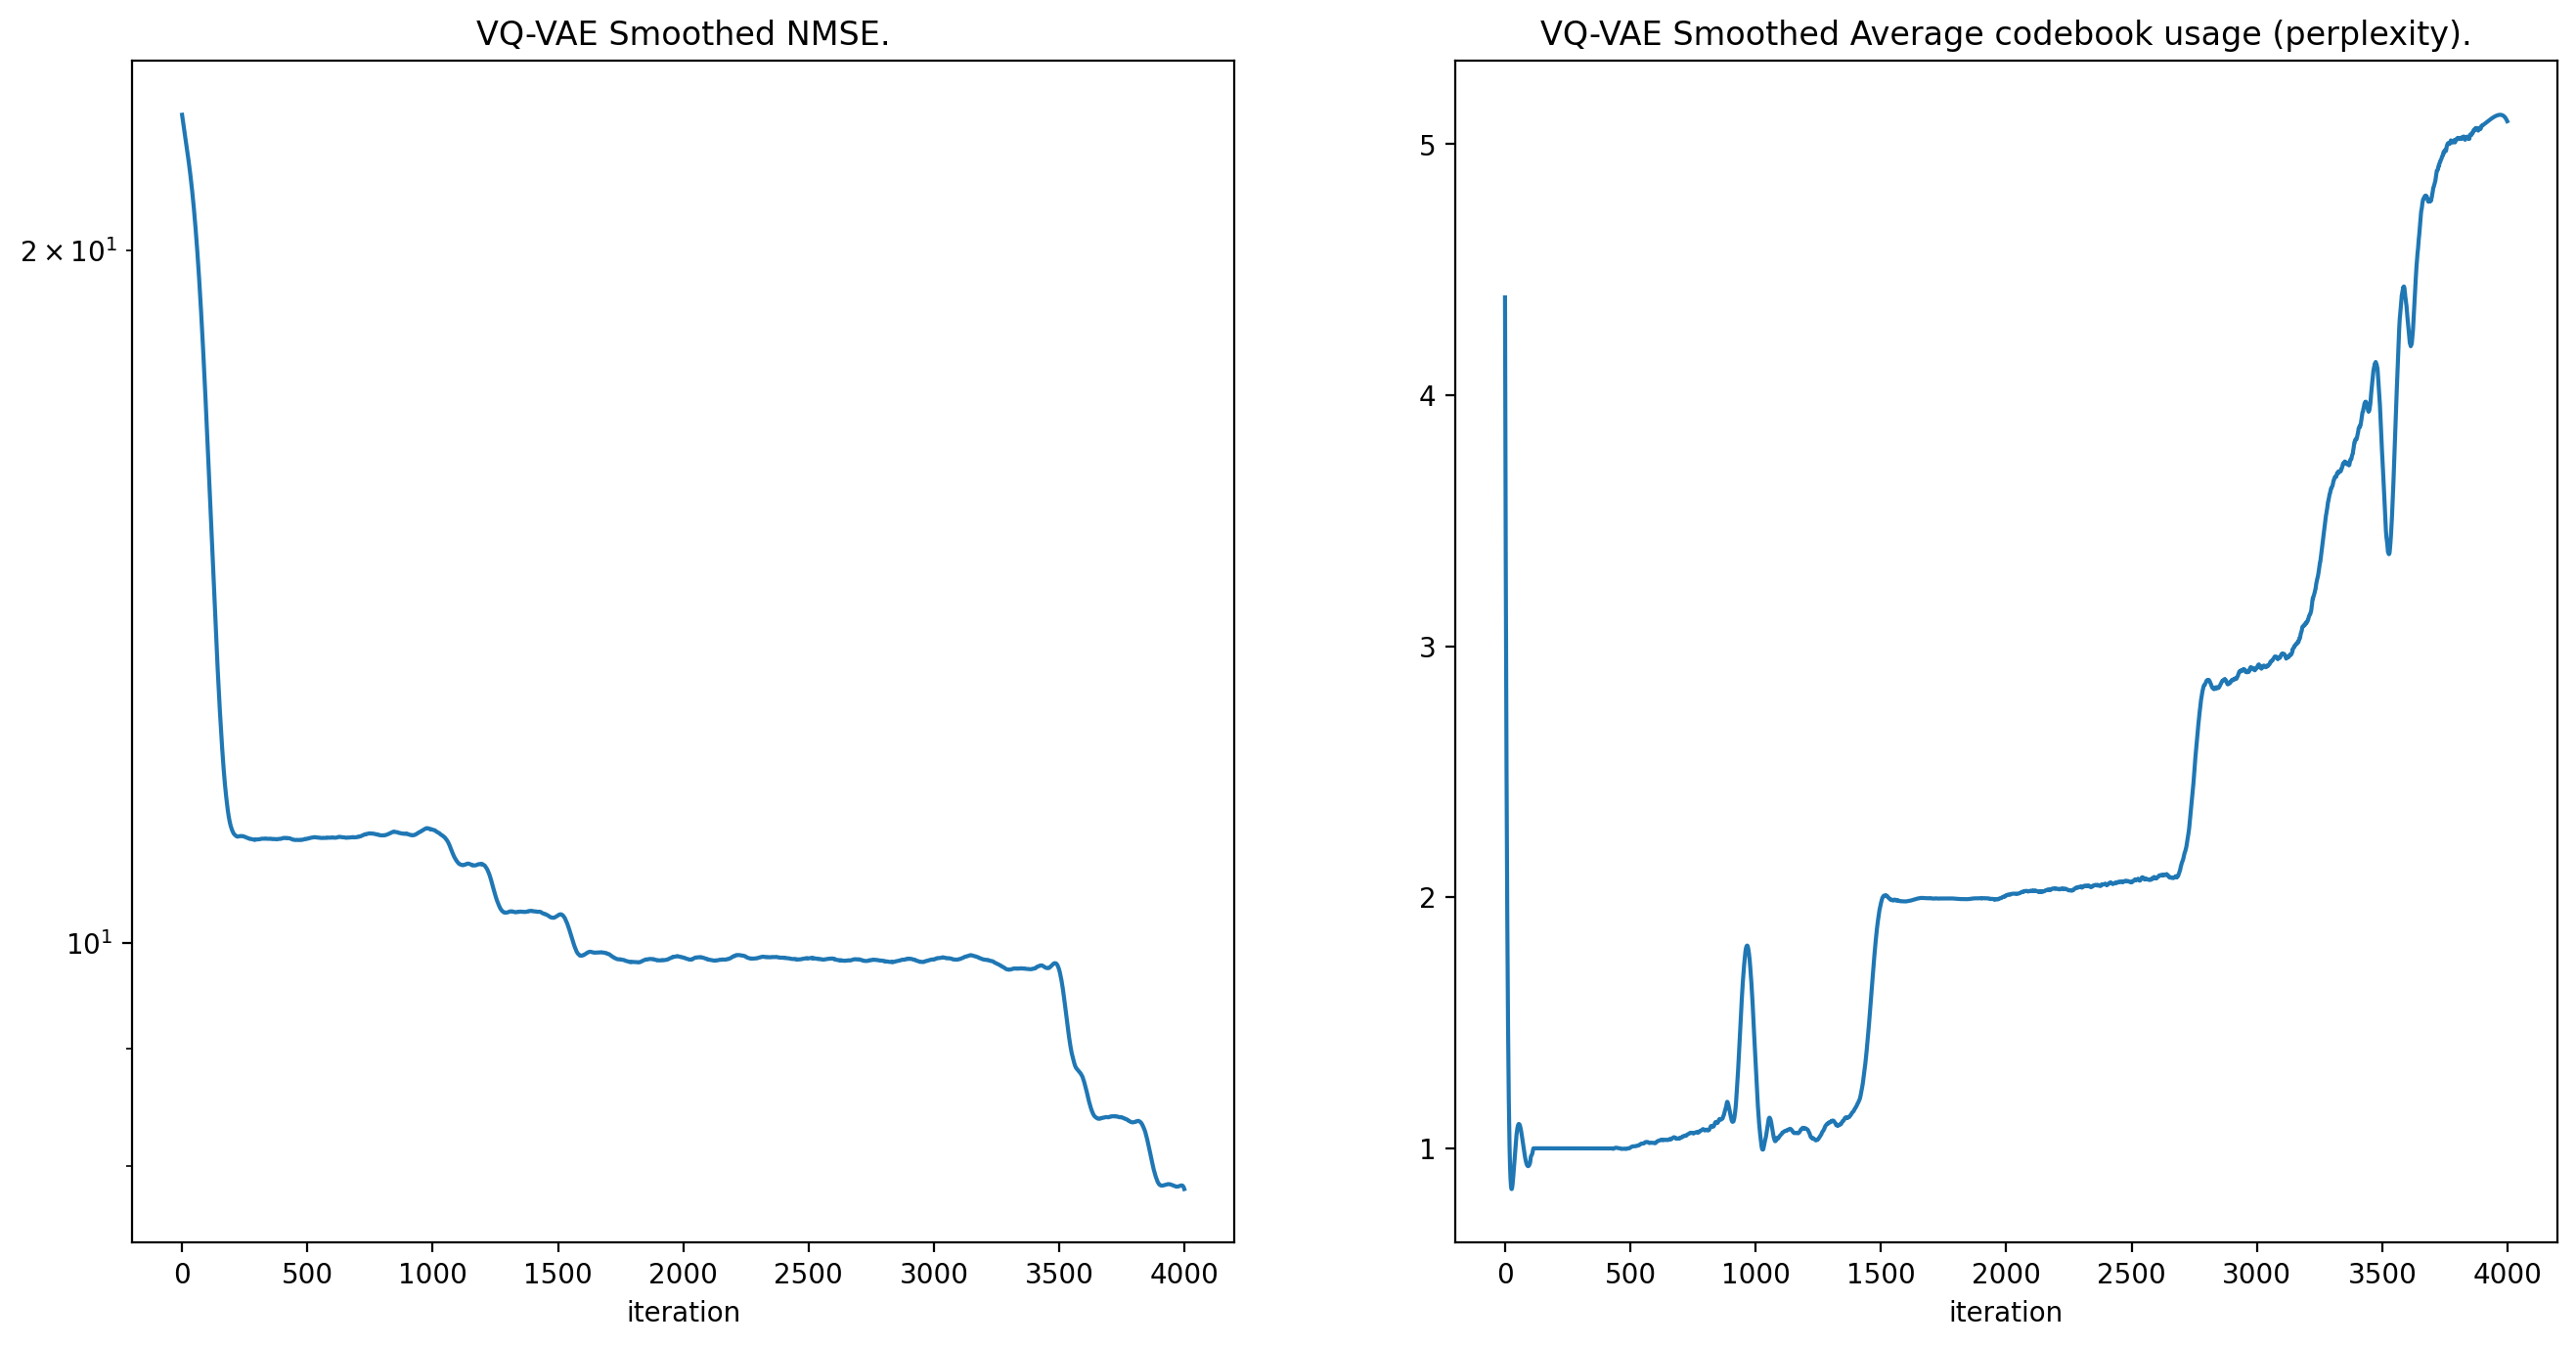

In [52]:
model = train_partial(soft_model, model, FVL['train'], cfg_p)

## Load / Save Models

In [53]:
torch.save(soft_model.state_dict(), 'vq_vae_double_mnist_full.pth')
torch.save(model.state_dict(), 'vq_vae_double_mnist_partial.pth')

In [46]:
soft_model.load_state_dict(torch.load('vq_vae_double_mnist_full.pth'))
#model.load_state_dict(torch.load('vq_vae_double_mnist_partial.pth'))

cpu = torch.device('cpu')
soft_model = soft_model.to(cpu)
#model = model.to(cpu)

## View Reconstructions

In [55]:
def show(img):
    plt.figure(figsize = (20,20))
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [23]:
def sample(model, validation_loader):
    model.eval()

    (valid_originals, _) = next(iter(validation_loader))
    valid_originals_ = valid_originals.to(device, dtype=torch.float)

    with torch.no_grad():
        vq_loss, valid_reconstructions, perplexity, encodings, encodings_idx = model(valid_originals_)

    # var_ = torch.reshape(var.detach().cpu(), (4, 8, -1)).numpy()
    # plt.figure(dpi=100)
    # plt.xticks([])
    # plt.yticks([])
    # plt.imshow(np.sum(var_, -1), interpolation='none')
    # plt.show()

    # probs_ = torch.reshape(probs.detach().cpu(), (4, 8, -1)).numpy()
    # plt.figure(dpi=100)
    # plt.xticks([])
    # plt.yticks([])
    # plt.imshow(np.sum(scipy.special.entr(probs_), -1), interpolation='none')
    # plt.show()
    encodings_idx = encodings_idx.view(32, 16, 16)[0, ::].detach()

    show(make_grid(valid_reconstructions.cpu().data)+0.5)
    show(make_grid(valid_originals.cpu()+0.5))
    show(make_grid(encodings_idx.cpu()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


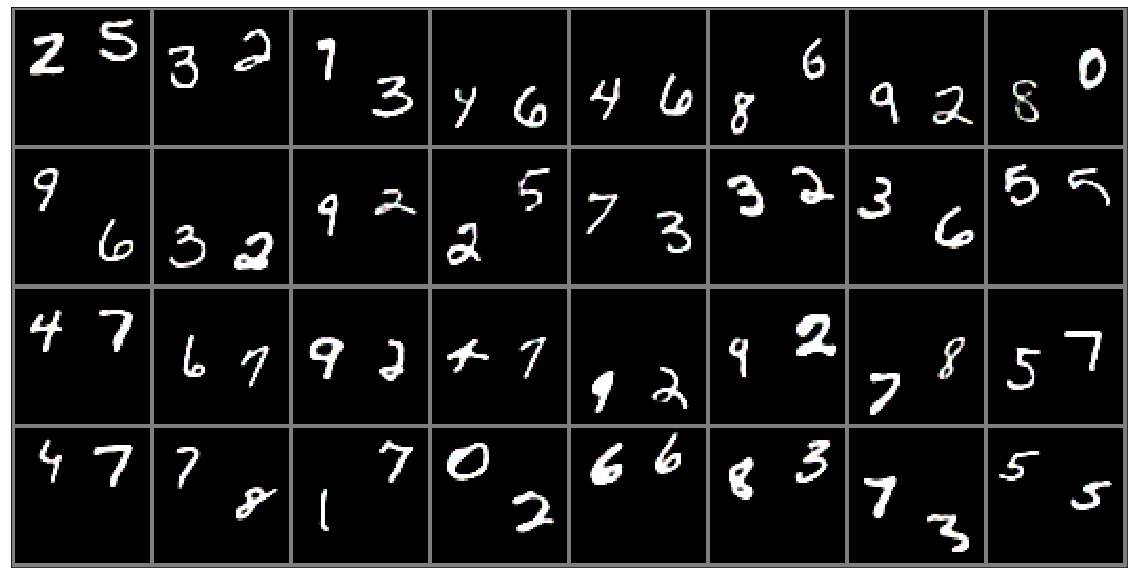

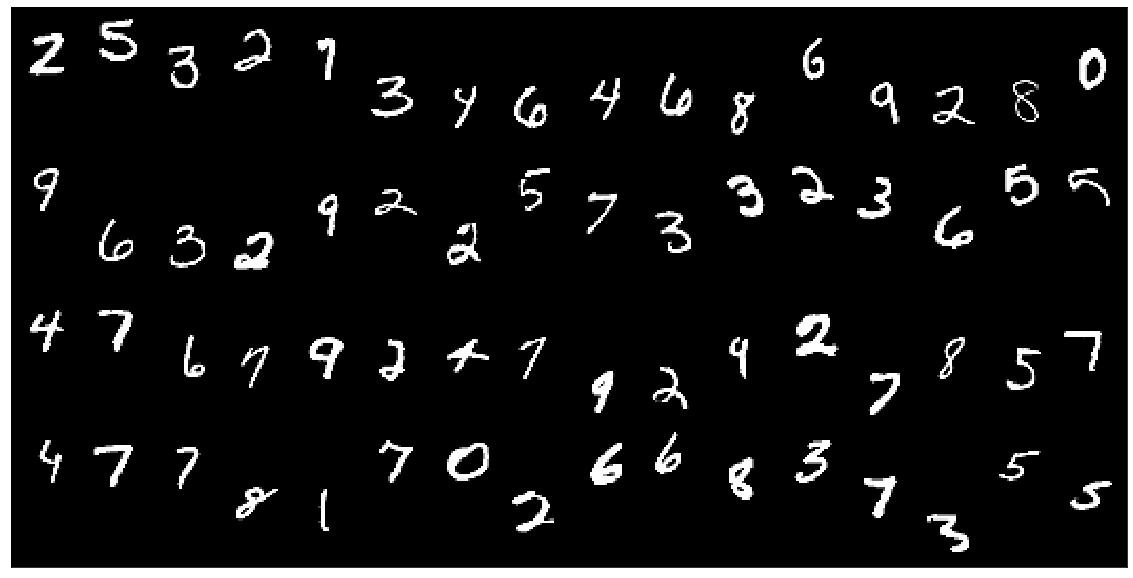

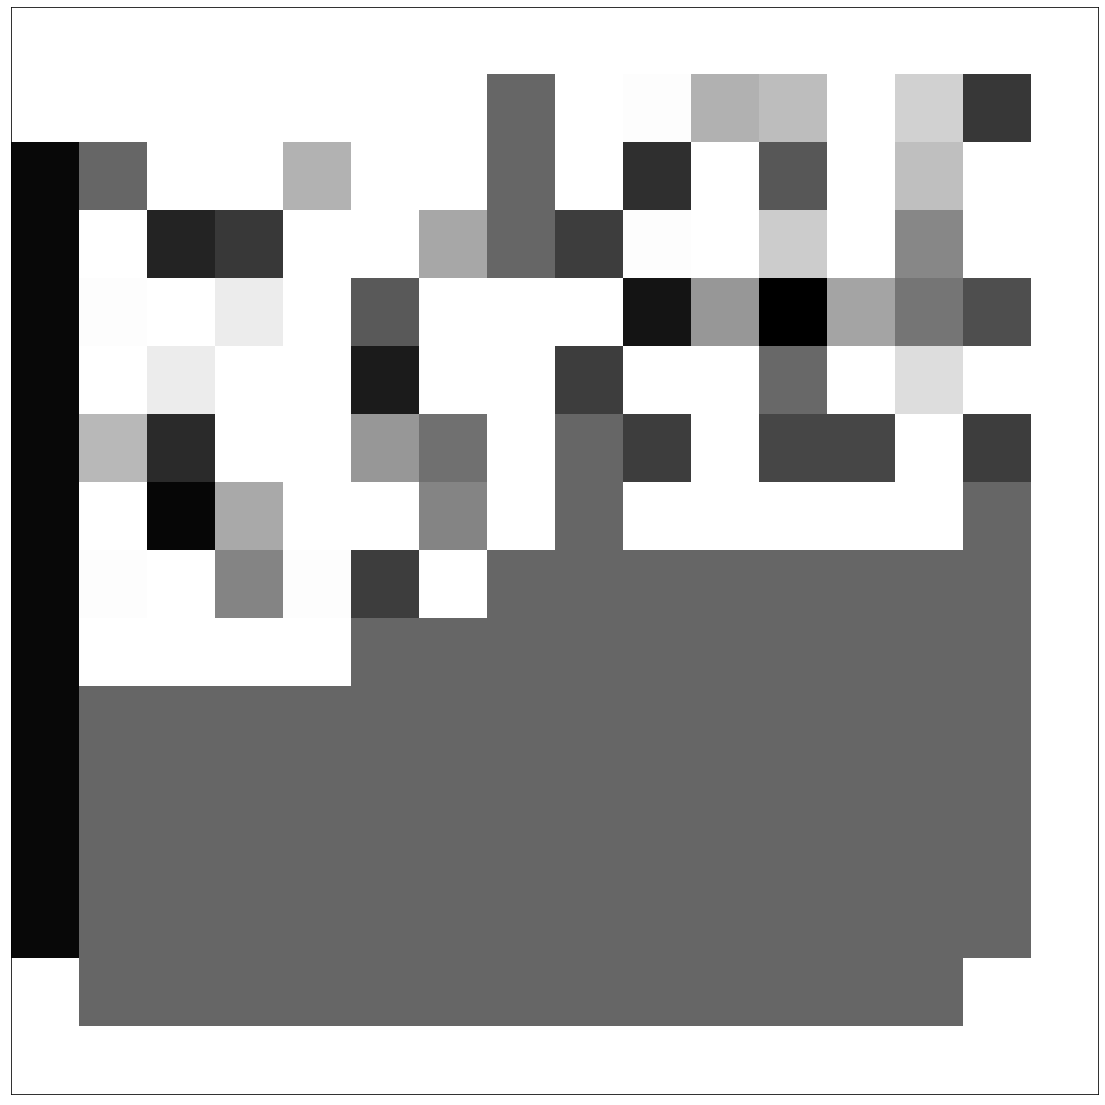

In [24]:
sample(soft_model, FVL['test'])

In [58]:
def sample_pv(valid_originals_, model_base, model, validation_loader):
    model.eval()
    model_base.eval()

    with torch.no_grad():
        # Forward pass throught the base model and extract encoding idxs
        z = model_base._encoder(valid_originals_)
        z = model_base._pre_vq_conv(z)
        _, _, _, _, encodings_idx = model_base._vq_vae(z)
        z = z.permute(0, 2, 3, 1)

        # Convert encoding idx to vector for second model
        encodings_idx_ = encodings_idx.view(valid_originals_.shape[0], 16, 16)/512.
        data = encodings_idx_.flatten(1)

        # Get reconstruction of encoding idx
        valid_reconstructions, _, _, _ = model(data)
        valid_reconstructions = valid_reconstructions*512.
        encodings_idx_recon = valid_reconstructions.to(dtype=torch.int64)
        # Reshape to match the shape of encodings we want
        encodings_idx_recon = encodings_idx_recon.flatten(0).unsqueeze(-1)

        # Perform quantization with reconstructed encoding idx vector
        encodings = torch.zeros(encodings_idx_recon.shape[0], model_base._vq_vae._num_embeddings, device=device)
        encodings.scatter_(1, encodings_idx_recon, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, model_base._vq_vae._embedding.weight).view(z.shape)
        # Straight Through Estimator
        quantized = z + (quantized - z)
        quantized = quantized.permute(0, 3, 1, 2)

        # Decode based on estimated encoding idx vector 
        x_recon = model_base._decoder(quantized)

    print(valid_reconstructions)

    show(make_grid(valid_reconstructions.cpu()))
    show(make_grid(data.cpu()))

    show(make_grid(x_recon.cpu()))
    show(make_grid(valid_originals_.cpu()))

In [59]:
for valid_originals, _ in FVL['test']:
	break

valid_originals = valid_originals.to(dtype=torch.float, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[  0.0000, 431.0957, 418.1565,  ..., 431.2469, 431.6966,   0.0000],
        [  0.0000, 427.2734, 408.1445,  ..., 430.0880, 427.3342,   0.0000],
        [  0.0000, 431.0957, 418.1565,  ..., 431.2469, 431.6966,   0.0000],
        ...,
        [  0.0000, 427.2738, 408.1450,  ..., 430.0881, 427.3340,   0.0000],
        [  0.0000, 427.2738, 408.1450,  ..., 430.0881, 427.3340,   0.0000],
        [  0.0000, 427.2734, 408.1445,  ..., 430.0880, 427.3342,   0.0000]],
       device='cuda:1')


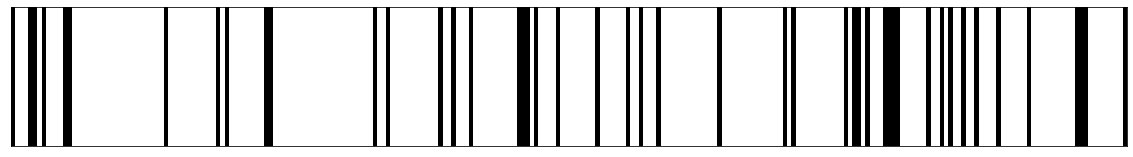

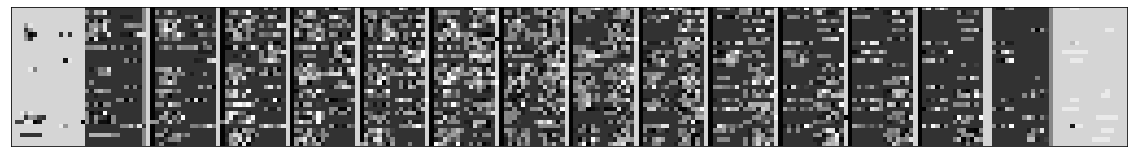

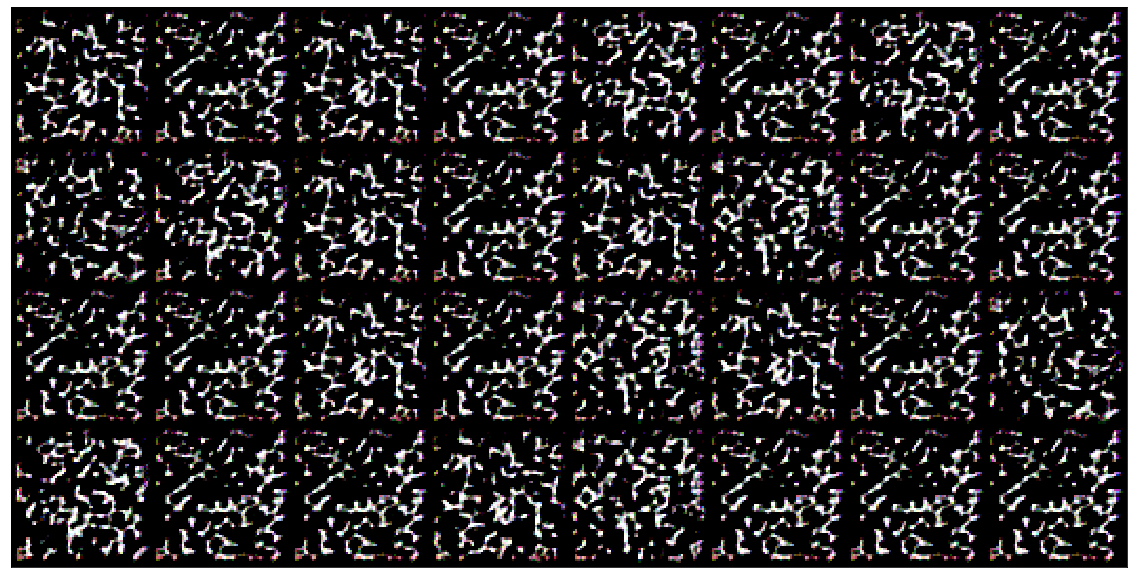

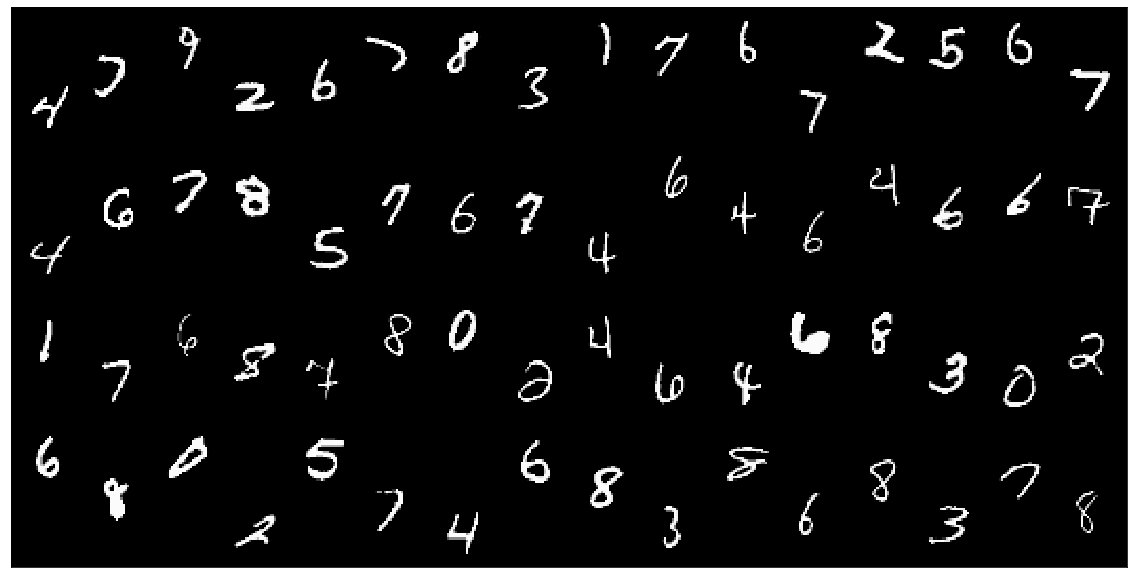

In [60]:
sample_pv(valid_originals, soft_model, model, FVL['test'])

## View Embedding

In [32]:
proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(soft_model._vq_vae._embedding.weight.data.cpu())

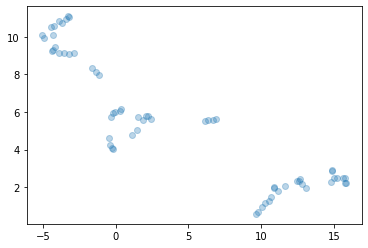

In [33]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)

In [34]:
proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model._vq_vae._embedding.weight.data.cpu())

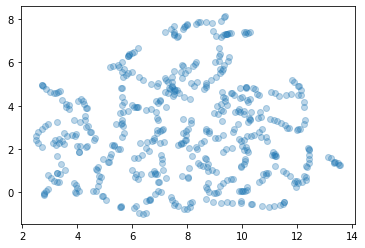

In [35]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)

## Learn Mappings

In [61]:
cfg_m = {
    'lr': 1e-4,
    'steps': 4000
}

In [62]:
class Mapper(nn.Module):
    def __init__(self, in_embeddings, out_embeddings, hidden_dim):
        super(Mapper, self).__init__()
        self.mapper = nn.Sequential(
            nn.Linear(in_embeddings, hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, out_embeddings),
            nn.ReLU()
        )
    def forward(self, x):
        return self.mapper(x)

In [63]:
mapper = Mapper(128, 128, 300)

In [94]:
def train_mapper(modelA, modelB, loader, cfg):
    optimizer = optim.Adam(model.parameters(), lr=cfg['lr'], amsgrad=False)
    model.train()
    train_error = []

    for i in trange(cfg['steps']):
        (data, _) = next(iter(loader))

        data_ = deepcopy(data.detach().cpu().numpy())
        a = rolling_window(data_, window=(14,14), asteps=None, wsteps=(4, 4), axes=None, toend=True)
        data = data.to(device, dtype=torch.float32)

        emb = modelB._vq_vae._embedding.weight.detach().cpu().numpy()

        with torch.no_grad():
            _, _, _, prob, soft_quantized = modelA(data)

        res = []
        for i in range(a.shape[0]):
            b = a[i, ::]
            b = b.swapaxes(1, 0).swapaxes(2, 1)
            b = b.reshape((-1, 14*14*3))
            b = torch.from_numpy(b).to(device, dtype=torch.float32)

            _, _, _, quantized = modelB(b)

            print(quantized.shape)
            print(np.where(emb == quantized.detach().cpu().numpy()[0, :]))
            res.append(quantized.detach())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        train_error.append(recon_error.item())

        if (i+1) % 10 == 0:
            print('%d iterations' % (i+1))
            print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
            # print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
            torch.save(model.state_dict(), 'vq_vae_ms_gleason2019_full.pth')
            print()

    train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
    train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

    f = plt.figure(figsize=(16,8), dpi=200)
    ax = f.add_subplot(1,2,1)
    ax.plot(train_res_recon_error_smooth)
    ax.set_yscale('log')
    ax.set_title('Soft-VQ-VAE Smoothed NMSE.')
    ax.set_xlabel('iteration')

    ax = f.add_subplot(1,2,2)
    ax.plot(train_res_perplexity_smooth)
    ax.set_title('Soft-VQ-VAE Smoothed Average codebook usage (perplexity).')
    ax.set_xlabel('iteration')

    plt.savefig('soft_model_plot.png')

    return model

In [95]:
train_mapper(soft_model, model, FVL['train'], cfg_m)

  0%|          | 0/4000 [00:00<?, ?it/s]

torch.Size([144, 512])
(array([], dtype=int64), array([], dtype=int64))
torch.Size([144, 512])
(array([], dtype=int64), array([], dtype=int64))
torch.Size([144, 512])
(array([], dtype=int64), array([], dtype=int64))
torch.Size([144, 512])
(array([], dtype=int64), array([], dtype=int64))
torch.Size([144, 512])
(array([], dtype=int64), array([], dtype=int64))
torch.Size([144, 512])
(array([], dtype=int64), array([], dtype=int64))
torch.Size([144, 512])
(array([], dtype=int64), array([], dtype=int64))
torch.Size([144, 512])
(array([], dtype=int64), array([], dtype=int64))
torch.Size([144, 512])
(array([], dtype=int64), array([], dtype=int64))
torch.Size([144, 512])
(array([], dtype=int64), array([], dtype=int64))
torch.Size([144, 512])
(array([], dtype=int64), array([], dtype=int64))
torch.Size([144, 512])
(array([], dtype=int64), array([], dtype=int64))
torch.Size([144, 512])
(array([], dtype=int64), array([], dtype=int64))
torch.Size([144, 512])
(array([], dtype=int64), array([], dtype=

NameError: name 'loss' is not defined